# *Baseline* and *Mitigation* Models - Testing

In [1]:
!pip install adversarial-robustness-toolbox torch matplotlib numpy


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import numpy as np
import matplotlib.pyplot as plt

/Users/harishsd/adversarial-attack-mitigation-system/project-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# defining model architecture

class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64,3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [5]:
# checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# loading baseline model

baseline_model = SimpleCNN().to(device)
baseline_model.load_state_dict(torch.load("../models/baseline_model.pth", map_location = device))
baseline_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# loading mitigation model

mitigation_model = SimpleCNN().to(device)
mitigation_model.load_state_dict(torch.load("../models/mitigation_model.pth", map_location = device))
mitigation_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
# preparing the test data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

100%|██████████| 9.91M/9.91M [00:19<00:00, 519kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 594kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.81MB/s]


In [9]:
# getting a single test sample

for image, label in test_loader:
    test_image = image.to(device)
    true_label = label.to(device)
    break

In [10]:
# generating an adversial attack

baseline_classifier_art = PyTorchClassifier(
    model = baseline_model,
    loss = nn.CrossEntropyLoss(),
    input_shape = (1, 28, 28),
    nb_classes = 10,
    device_type = "gpu" if torch.cuda.is_available() else "cpu"
)

pgd_attack = ProjectedGradientDescent(baseline_classifier_art, eps = 0.3)
x_adv_np = pgd_attack.generate(x = test_image.cpu().numpy(), y = true_label.cpu().numpy())
x_adv_tensor = torch.from_numpy(x_adv_np).to(device)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]/Users/harishsd/adversarial-attack-mitigation-system/project-env/lib/python3.13/site-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [11]:
# running test on both models

print("Testing vulnerable baseline model...")
with torch.no_grad():
    output_clean = baseline_model(test_image)
    pred_clean = output_clean.argmax(dim = 1).item()
    print(f"Clean image prediction: {pred_clean} (True: {true_label.item()})")

    output_adv = baseline_model(x_adv_tensor)
    pred_adv = output_adv.argmax(dim = 1).item()
    print(f"Adversarial image prediction: {pred_adv} (True: {true_label.item()})")

print("Testing mitigation model...")
with torch.no_grad():
    mitigation_output_clean = mitigation_model(test_image)
    mitigation_pred_clean = mitigation_output_clean.argmax(dim = 1).item()
    print(f"Clean image predicted as: {pred_adv} (True: {true_label.item()})")

    mitigation_output_adv = mitigation_model(x_adv_tensor)
    mitigation_pred_adv = mitigation_output_adv.argmax(dim = 1).item()
    print(f"Adversarial image predicted as: {mitigation_pred_adv} (True: {true_label.item()})")

Testing vulnerable baseline model...
Clean image prediction: 7 (True: 7)
Adversarial image prediction: 2 (True: 7)
Testing mitigation model...
Clean image predicted as: 2 (True: 7)
Adversarial image predicted as: 7 (True: 7)


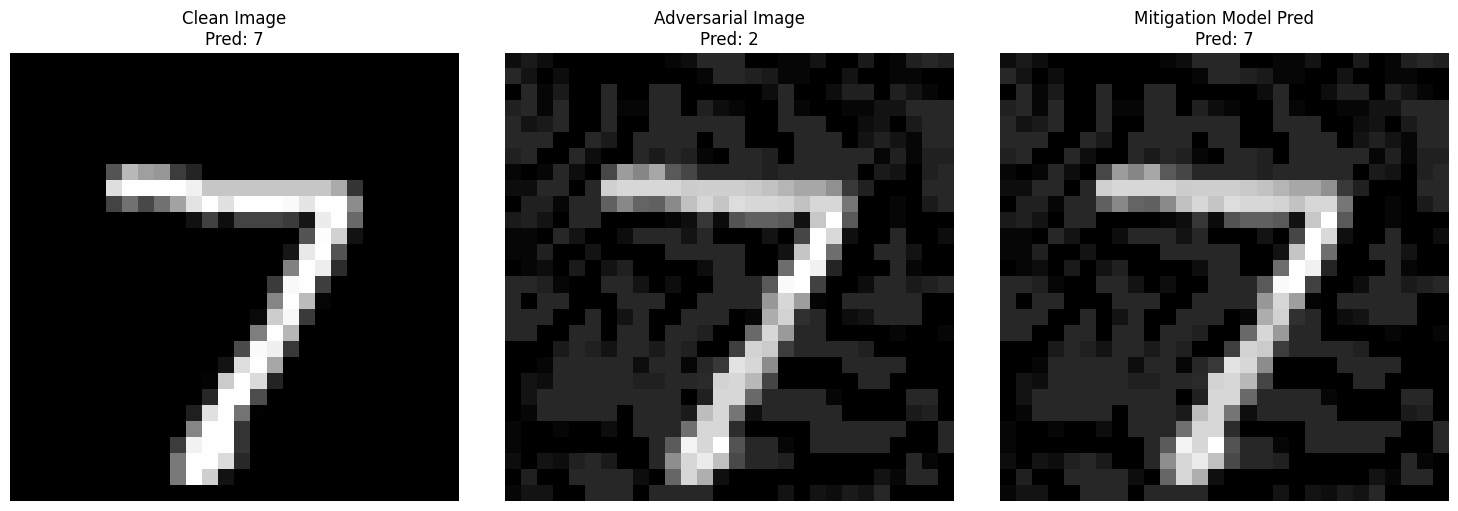

In [12]:
# visualizing the results

fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# clean image
axes[0].imshow(test_image.cpu().squeeze().numpy(), cmap = 'gray')
axes[0].set_title(f"Clean Image\nPred: {pred_clean}")
axes[0].axis("off")

# baseline model's pred of adversarial image
axes[1].imshow(x_adv_tensor.cpu().squeeze().numpy(), cmap = "gray")
axes[1].set_title(f"Adversarial Image\nPred: {pred_adv}")
axes[1].axis("off")

# mitigation model's pred of adversarial image
axes[2].imshow(x_adv_tensor.cpu().squeeze().numpy(), cmap = "gray")
axes[2].set_title(f"Mitigation Model Pred\nPred: {mitigation_pred_adv}")
axes[2].axis("off")

plt.tight_layout()
plt.show()
